<a href="https://colab.research.google.com/github/ks4617/ASTR-Leistedt-1/blob/main/jax_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  
import jax
from jax.interpreters import xla
xla._xla_callable.cache_clear()

from jax.config import config
config.update("jax_enable_x64", True)

In [ ]:
# Import modules
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap, device_put, partial
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from numpy.linalg import inv
from numpy.linalg import slogdet
from scipy.optimize import minimize
from jax.ops import index, index_update
import pandas as pd

In [ ]:
# Load data
data = np.load('spec4000error.npz')

# Standard PCA

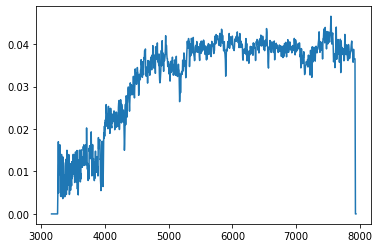

Number of capped errors 6756


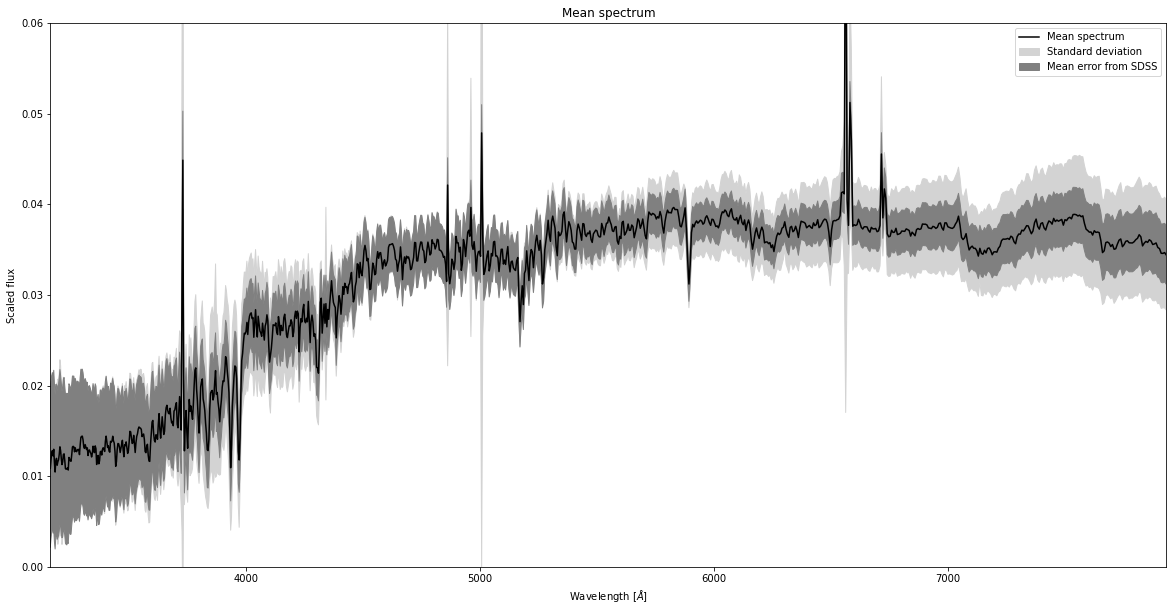

In [ ]:
#%% Calculating wavlength grid from coefficients

log_wavelengths = data['coeff0'] + data['coeff1'] * np.arange(0, 1000, 1)
wavelengths = [10**i for i in log_wavelengths]

#%% Selecting only galaxies (spec_cln = 2)

galaxy_ind = data['spec_cln'] == 2
X = data['spectra'][galaxy_ind]
subclass = data['lineindex_cln'][galaxy_ind]
z = data['z'][galaxy_ind]
z_err = data['zerr'][galaxy_ind]
spec_err = data['spec_err'][galaxy_ind]

#%% Set any negative spikes in flux to zero and set the corresponding error to zero

neg_ind = X <= 0.
X[neg_ind] = 0.
spec_err[neg_ind] = 0.

#%% Set zero fluxes to NaN

X_nonan = X.copy()
zero_ind = X == 0.
X[zero_ind] = np.NaN

#%% Set all zero and negative flux errors to NaN

zero_err_ind = spec_err <= 0.
spec_err[zero_err_ind] = np.NaN

#%% Normalise spectrum
X_normal, norm = preprocessing.normalize(X_nonan, return_norm=True)
X_norm_zeros = np.copy(X_normal)

#%% Plot an example spectrum in the data
plt.figure()
plt.plot(wavelengths,X_normal[4])
plt.show()

#%% Set all zero normalised fluxes to nan
zero_norm_ind = X_normal == 0.
X_normal[zero_norm_ind] = np.NaN

#%% Transform errors due to corresponding normalisation
spec_err_T = np.transpose(spec_err)
spec_err_norm_T = np.divide(spec_err_T,norm)
spec_err_norm = np.transpose(spec_err_norm_T)

# %% Cap errors at a lower limit of 1e-5 times the flux
cap_counter = 0
for spectra in range(len(spec_err_norm)):
    for pixel in range(len(spec_err_norm[spectra])):
        if np.isnan(spec_err_norm[spectra][pixel]) == False and spec_err_norm[spectra][pixel] < 1e-5 * X_normal[spectra][pixel]:
            spec_err_norm[spectra][pixel] = 1e-5 * X_normal[spectra][pixel]
            cap_counter += 1
print("Number of capped errors", cap_counter)

#%% Spectra errors with infs instead of nans
spec_err_norm_inf = np.nan_to_num(spec_err_norm,nan=np.inf)

#%% Plot mean spectrum
mu = np.nanmean(X_normal, axis=0)
std = np.nanstd(X_normal, axis=0)
#mu = X_norm_zeros.mean(0)
#std = X_norm_zeros.std(0)
mean_err = np.nanmean(spec_err_norm, axis=0)
plt.figure(figsize=(20,10))
plt.plot(wavelengths, mu, color = 'black', label='Mean spectrum')
plt.fill_between(wavelengths, mu - std, mu + std , color = 'lightgrey', label='Standard deviation')
plt.fill_between(wavelengths, mu - mean_err, mu + mean_err , color = 'grey', label = 'Mean error from SDSS')
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(0,0.06)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Scaled flux')
plt.title('Mean spectrum')
plt.legend()
plt.show()

#%% Apply PCA
pca = PCA(n_components=4)
X_red = pca.fit_transform(X_norm_zeros)

#%% Fill spectra minus mean to be filled with zeros at nan values
X_mu = X_normal - mu
X_mu_zeros = np.nan_to_num(X_mu,nan=0.)

# Bayesian PCA

In [ ]:
# Store W (have to transpose because pca.components_ has different dimensions to W in the equations)
W = pca.components_.T 

In [ ]:
def sig_inv_diag_all(spec_err_norm_inf):
  sig_inv_diag_arr = spec_err_norm_inf ** (-2)
  log_sig = np.log(sig_inv_diag_arr)
  log_sig[log_sig == -np.inf] = 0.
  logdet_sig_arr = np.array([np.sum(i) for i in log_sig])
  return sig_inv_diag_arr, logdet_sig_arr

In [ ]:
sig_inv_diag_arr, logdet_sig_arr = sig_inv_diag_all(spec_err_norm_inf)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
ident = jnp.identity(W.shape[1])

def ln_onespec1(W, X_mu_zeros_n, sig_inv_diag, logdet_sig, ident):
  sig_inv = jnp.diagflat(sig_inv_diag)
  sig_inv_W = sig_inv_diag[:,None]*W
  #sig_inv_W = jnp.matmul(sig_inv,W)

  M = ident + jnp.matmul(W.T, sig_inv_W)
  M_inv = jnp.linalg.solve(M, ident)
  C_inv = sig_inv -  jnp.matmul(sig_inv_W, jnp.matmul(M_inv, sig_inv_W.T))
  _, logdet_M = jnp.linalg.slogdet(M)

  l_n = -0.5*X_mu_zeros_n.shape[0]*jnp.log(2*jnp.pi) - 0.5*(logdet_M - logdet_sig) - 0.5*jnp.matmul(X_mu_zeros_n.T,jnp.matmul(C_inv,X_mu_zeros_n))

  return l_n

def ln_onespec(W, X_mu_zeros_n, sig_inv_diag, logdet_sig, ident):
  sig_inv = jnp.diagflat(sig_inv_diag)
  sig_inv_W = sig_inv_diag[:,None]*W

  M = ident + jnp.matmul(W.T, sig_inv_W)
  M_inv = jnp.linalg.solve(M,ident)
 
  W_sig = sig_inv_W.T  # = jnp.matmul(W.T,sig_inv) 
  W_sig_X = jnp.matmul(W_sig, X_mu_zeros_n)
  Minv_W_sig_X = jnp.matmul(M_inv, W_sig_X)
  Cinv_2 = jnp.matmul(sig_inv_W, Minv_W_sig_X)
  Cinv_1 = jnp.matmul(sig_inv, X_mu_zeros_n)
  Cinv_X = Cinv_1 - Cinv_2

  #C_inv = sig_inv -  jnp.matmul(sig_inv_W, jnp.matmul(M_inv, sig_inv_W.T))

  _, logdet_M = jnp.linalg.slogdet(M)

  l_n = -0.5*X_mu_zeros_n.shape[0]*jnp.log(2*jnp.pi) - 0.5*(logdet_M - logdet_sig) - 0.5*jnp.matmul(X_mu_zeros_n.T, Cinv_X) #- 0.5*jnp.matmul(X_mu_zeros_n.T,jnp.matmul(C_inv,X_mu_zeros_n))

  return l_n


In [ ]:
print(ln_onespec(W, X_mu_zeros[3100], sig_inv_diag_arr[3100], logdet_sig_arr[3100], ident))
print(ln_onespec1(W, X_mu_zeros[3100], sig_inv_diag_arr[3100], logdet_sig_arr[3100], ident))

4586.985988882617
4586.985969507304


In [ ]:
#@partial(jit, static_argnums=(1))
def ln_allspec(W, data1):
  X_mu_zeros, sig_inv_diag_arr, logdet_sig_arr, ident = data1
  ln_total = 0
  for i in range(X_mu_zeros.shape[0]):
    ln_total += ln_onespec(W[0], X_mu_zeros[i], sig_inv_diag_arr[i], logdet_sig_arr[i], ident)
  return ln_total

In [ ]:
# CHECK LN_TOTAL FOR ALL SPECTRA
ln_total = 0
for i in range(len(X_mu_zeros)):
  ln_total += ln_onespec(W, X_mu_zeros[i], sig_inv_diag_arr[i], logdet_sig_arr[i], ident)

ln_total

DeviceArray(-4.04196053e+11, dtype=float64)

In [ ]:
ident = jnp.identity(W.shape[1])

def ln_onespec(W,ident, X_mu_zeros_n, sig_inv_diag, logdet_sig):
  sig_inv_W = sig_inv_diag[:,None]*W

  M = ident + jnp.matmul(W.T, sig_inv_W)
  M_inv = jnp.linalg.solve(M,ident)
  _, logdet_M = jnp.linalg.slogdet(M)

  W_sig = sig_inv_W.T
  W_sig_X = jnp.matmul(W_sig, X_mu_zeros_n)
  Minv_W_sig_X = jnp.matmul(M_inv, W_sig_X)
  Cinv_2 = jnp.matmul(sig_inv_W, Minv_W_sig_X)
  Cinv_1 = sig_inv_diag*X_mu_zeros_n
  Cinv_X = Cinv_1 - Cinv_2
    
  l_n = -0.5*X_mu_zeros_n.shape[0]*jnp.log(2*jnp.pi) -0.5*(logdet_M - logdet_sig) -0.5*jnp.matmul(X_mu_zeros_n.T, Cinv_X)  

  return l_n

In [ ]:
def ln_allspec(W, data1):
  ident, X_mu_zeros, sig_inv_diag_arr, logdet_sig_arr = data1
  W = W[0]
  return -sum(vmap(ln_onespec, in_axes=(None,None,0,0,0))(W, ident, X_mu_zeros, sig_inv_diag_arr, logdet_sig_arr))

In [ ]:
data1 = (ident, X_mu_zeros, sig_inv_diag_arr, logdet_sig_arr)
ln_allspec([1*W], data1)

571660362934.0212

In [ ]:
from jax.experimental import optimizers
param_list = [1*W]
learning_rate = 1e-5
opt_init, opt_update, get_params = jax.experimental.optimizers.adam(learning_rate)
opt_state = opt_init(param_list)

#@partial(jit, static_argnums=(2))
def update(step, opt_state, data1):
  params = get_params(opt_state)
  value, grads = jax.value_and_grad(ln_allspec)(params,data1)
  opt_state = opt_update(step, grads, opt_state)
  return value, opt_state

num_iterations = 10

data1 = (ident, jnp.array(X_mu_zeros), jnp.array(sig_inv_diag_arr), jnp.array(logdet_sig_arr))
for step in range(num_iterations):
  # Could potentially also iterate over batches of data
  loss_value, opt_state = update(step, opt_state, data1)

# optimised matrix:
W_new_optimised = get_params(opt_state)

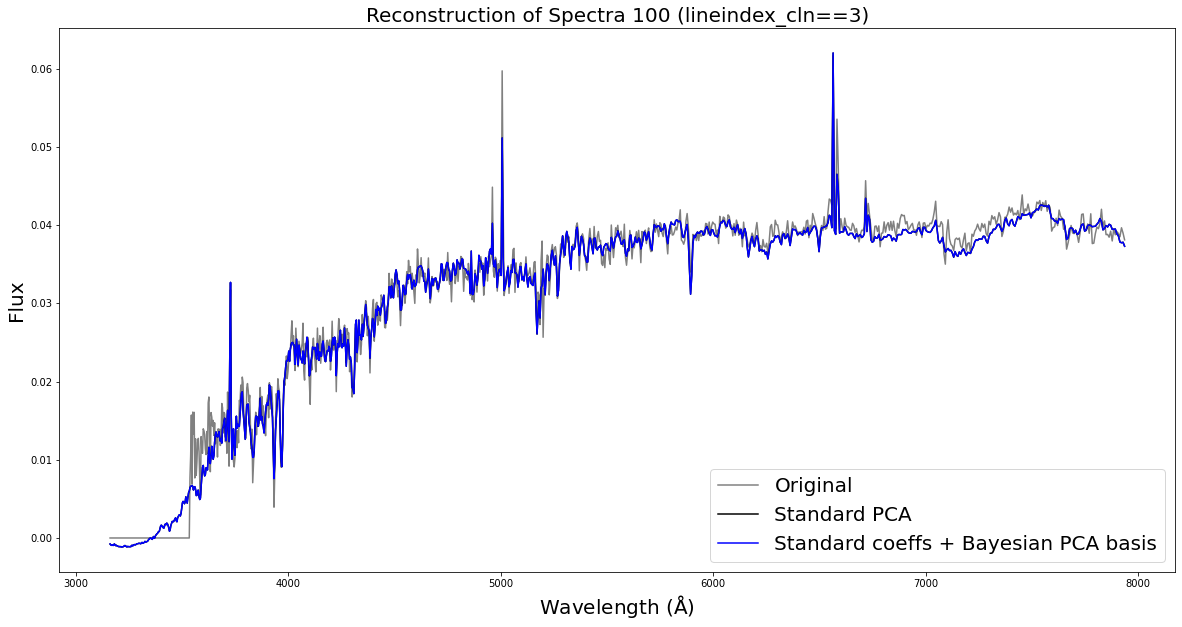

In [ ]:
spectra_num = 100
fig = plt.figure(figsize=(20,10))
plt.plot(wavelengths, X_norm_zeros[spectra_num], '-', c='gray', label='Original')
plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spectra_num], pca.components_), '-k', label='Standard PCA')
plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spectra_num], np.array(W_new_optimised[0]).T), '-b', label='Standard coeffs + Bayesian PCA basis')
plt.ylabel('Flux', fontsize=20)
plt.xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
plt.title(f'Reconstruction of Spectra {spectra_num} (lineindex_cln=={subclass[spectra_num]})', fontsize=20)
plt.legend(fontsize=20)
plt.show()

# Bayesian coefficients

In [ ]:
# Function to retrieve PCA coefficients from a PCA
def bayesian_coeffs1(W, X_mu_zeros_n, sig_inv_diag, ident):
# y and yinvvvar are arrays of shape npix_y (one SED and its inverse variance vector)
# M_T is the transpose of the PCA components array, of shape (n_components, n_pix_y)
  #W_T = np.transpose(W)  # (n_pix_y, n_components) # trivial but I don't know if you work with M or M_T
  Myinv = W * sig_inv_diag[:, None]  # (n_pix_y, n_components)
  Hbar = np.matmul(W.T, Myinv) + ident #  (n_components, n_components)
  etabar = np.sum(Myinv * X_mu_zeros_n[:, None], axis=0)  # (n_components)
  theta_map = np.linalg.solve(Hbar, etabar) # result: maximum a posteriori
  return theta_map

In [ ]:
# Function to retrieve PCA coefficients from a PCA
def bayesian_coeffs(W, X_mu_zeros_n, sig_inv_diag, ident):
  W_siginv_X = np.matmul(W.T,sig_inv_diag*X_mu_zeros_n)
  M = np.matmul(W.T, sig_inv_diag[:, None]*W) + ident
  z_map = np.linalg.solve(M, W_siginv_X)
  return z_map

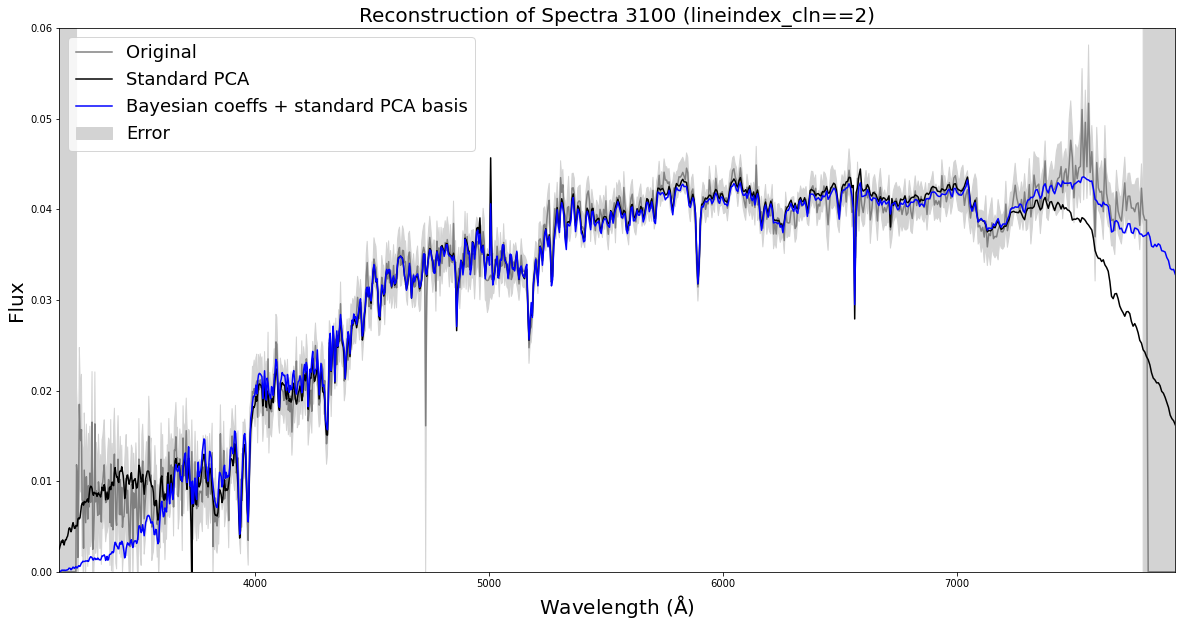

In [ ]:
spec_num = 3100
fig = plt.figure(figsize=(20,10))

plt.plot(wavelengths, X_norm_zeros[spec_num], '-', c='gray', label='Original')
plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spec_num], pca.components_), '-k', label='Standard PCA')
plt.plot(wavelengths, pca.mean_ + np.dot(bayesian_coeffs(W, X_mu_zeros[spec_num],sig_inv_diag_arr[spec_num], ident), W.T), '-b', label='Bayesian coeffs + standard PCA basis')
#plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spec_num], np.array(W_new_optimised[0]).T), '-b', label='Standard coeffs + Bayesian PCA basis')
#plt.plot(wavelengths, pca.mean_ + np.dot(bayesian_coeffs(W, X_mu_zeros[spec_num],sig_inv_diag_arr[spec_num]), W_new_optimised[0].T), '-g', label='Bayesian coeffs + Bayesian PCA basis')

spec_err_norm_large = np.copy(spec_err_norm_inf)
spec_err_norm_large[spec_err_norm_large==np.inf] = 10
plt.fill_between(wavelengths, X_norm_zeros[spec_num] - spec_err_norm_large[spec_num], X_norm_zeros[spec_num] + spec_err_norm_large[spec_num] , color = 'lightgrey', label='Error')
#plt.plot(wavelengths,spec_err_norm_large[spec_num], color='orange', label='Error')
#plt.fill_between(wavelengths, X_norm_zeros[spec_num] - spec_err_norm_inf[spec_num], X_norm_zeros[spec_num] + spec_err_norm_inf[spec_num] , color = 'lightgrey', label='Error')
#plt.plot(wavelengths,spec_err_norm_inf[spec_num], color='orange', label='Error')
plt.ylim(0,0.06)
plt.xlim(wavelengths[0],wavelengths[-1])

plt.ylabel('Flux', fontsize=20)
plt.xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
plt.title(f'Reconstruction of Spectra {spec_num} (lineindex_cln=={subclass[spec_num]})', fontsize=20)
plt.legend(fontsize=18)
plt.show()

In [ ]:
np.save('W_new_optimised_10iter_1e-5lr.npy', np.asarray(W_new_optimised[0]))

# Plots and stuff

In [ ]:
W_optimised_arr = np.asarray(W_new_optimised[0])
coeffs_optimised = np.zeros(4)
for i in range(X_mu_zeros.shape[0]):
  coeffs_optimised = np.vstack((coeffs_optimised, bayesian_coeffs(W_optimised_arr, X_mu_zeros[i],sig_inv_diag_arr[i], ident)))

coeffs_optimised = np.delete(coeffs_optimised, 0, 0)

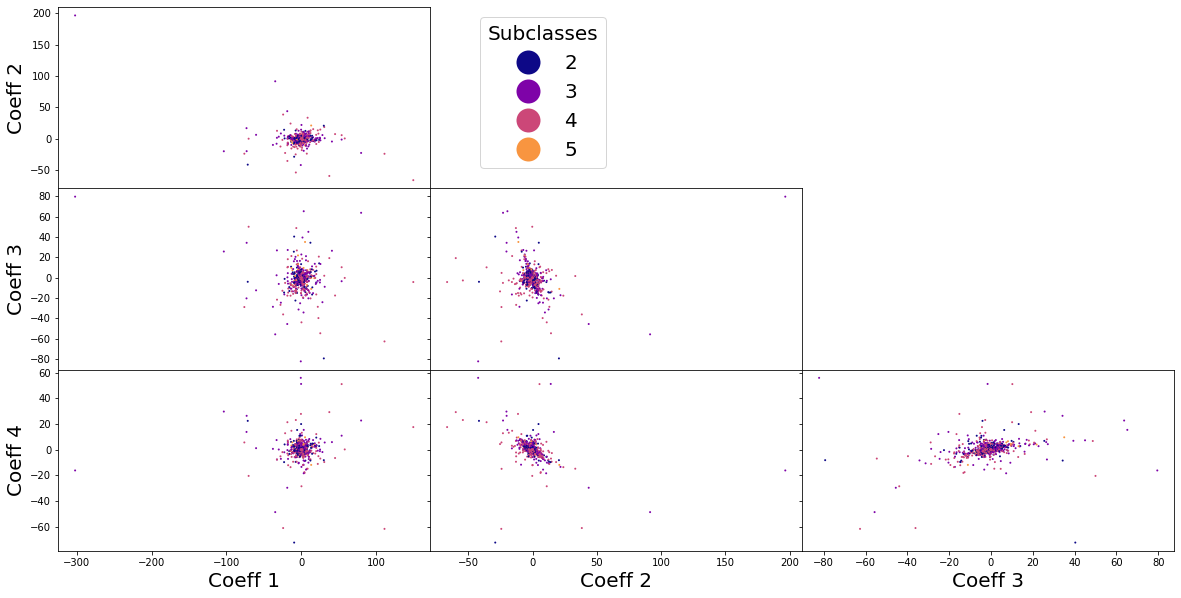

In [ ]:
# Plotting optimised Bayesian coefficients against each other
plt.figure(figsize=(20,10))
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.set_cmap('plasma')

ax1 = plt.subplot(3,3,1)
scatter1 = ax1.scatter(coeffs_optimised[:, 0], coeffs_optimised[:, 1], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax1.set_ylabel('Coeff 2', fontsize=20)

ax2 = plt.subplot(3,3,4)
ax2.scatter(coeffs_optimised[:, 0], coeffs_optimised[:, 2], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax2.set_ylabel('Coeff 3', fontsize=20)

ax3 = plt.subplot(3,3,5)
ax3.scatter(coeffs_optimised[:, 1], coeffs_optimised[:, 2], c = subclass, s=4, lw=0, vmin=2, vmax=6)

ax4 = plt.subplot(3,3,7)
ax4.scatter(coeffs_optimised[:, 0], coeffs_optimised[:, 3], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax4.set_xlabel('Coeff 1', fontsize=20)
ax4.set_ylabel('Coeff 4', fontsize=20)

ax5 = plt.subplot(3,3,8)
ax5.scatter(coeffs_optimised[:, 1], coeffs_optimised[:, 3], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax5.set_xlabel('Coeff 2', fontsize=20)

ax6 = plt.subplot(3,3,9)
ax6.scatter(coeffs_optimised[:, 2], coeffs_optimised[:, 3], c = subclass, s=4, lw=0, vmin=2, vmax=6)
ax6.set_xlabel('Coeff 3', fontsize=20)

plt.subplots_adjust(hspace=.0, wspace=.0)
axs = np.array([ax1, ax2, ax3, ax4, ax5, ax6])
for ax in axs.flat:
    ax.label_outer()
    
ax1.legend(*scatter1.legend_elements(), bbox_to_anchor=(1.5, 1), title="Subclasses",
                     fontsize=20, title_fontsize=20, markerscale=4)

plt.show()

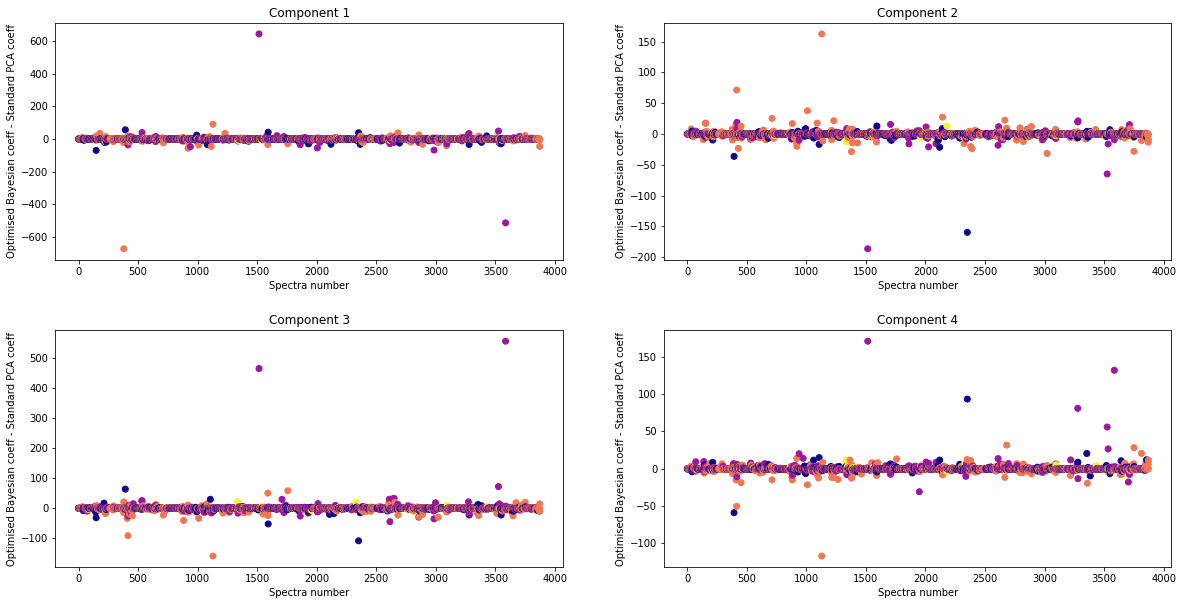

In [ ]:
coeff_diff = coeffs_optimised - X_red
plt.figure(figsize=(20,10))
for i in range(coeffs_optimised.shape[1]):
  ax = plt.subplot(2,2,i+1)
  ax.scatter(range(coeffs_optimised.shape[0]), coeff_diff[:,i], c=subclass)
  ax.set_title(f'Component {i+1}')
  ax.set_xlabel('Spectra number')
  ax.set_ylabel('Optimised Bayesian coeff - Standard PCA coeff')
plt.subplots_adjust(hspace=.3, wspace=.2)
plt.show()

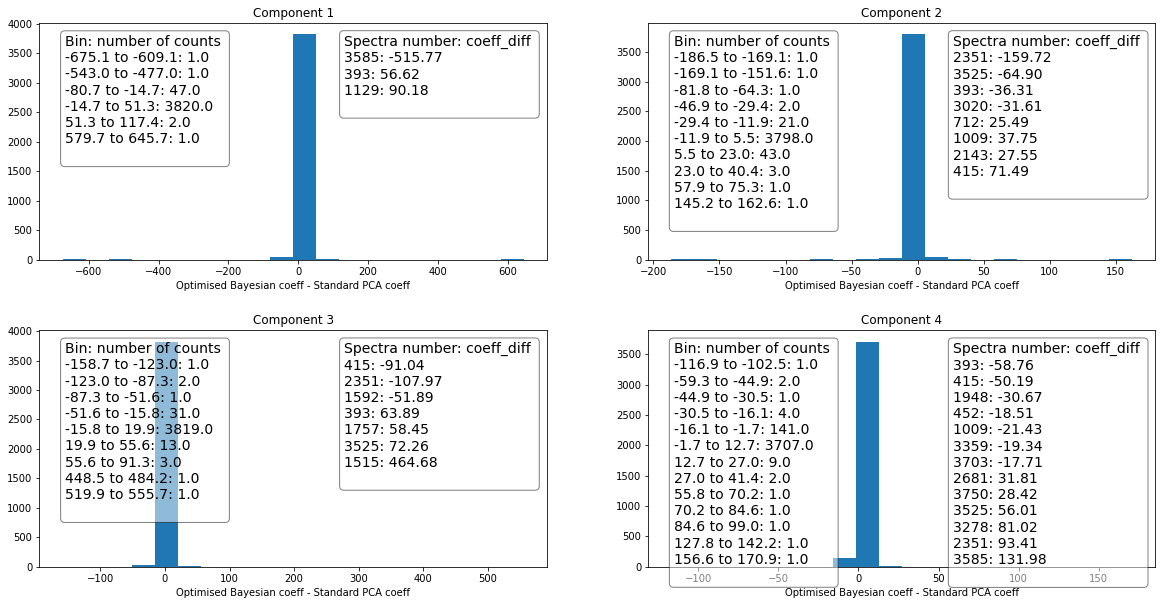

In [ ]:
plt.figure(figsize=(20,10))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
outliers_dict = {}
for i in range(coeffs_optimised.shape[1]):
  outliers_dict[f'{i+1}'] = np.array([])
  ax = plt.subplot(2,2,i+1)
  counts, bins, _ = ax.hist(coeff_diff[:,i], bins=20)
  bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
  bin_y_centers = ax.get_yticks()[1] * 0.25
  text_left = 'Bin: number of counts \n'
  text_right = 'Spectra number: coeff_diff \n'
  for j in range(len(bins)-1):
    if counts[j] != 0:
      bin_label = f'{bins[j]:.1f} to {bins[j+1]:.1f}: {counts[j]}\n'
      text_left += bin_label
      #ax.text(bin_x_centers[j], bin_y_centers, bin_label, horizontalalignment='center')
      if counts[j] < 5.:
        for k in coeff_diff[:,i][(coeff_diff[:,i] > bins[j]) & (coeff_diff[:,i] < bins[j+1])]:
          outliers_dict[f'{i+1}'] = np.append(outliers_dict[f'{i+1}'],np.where(coeff_diff[:,i] == k)[0][0])
          text_right += f'{np.where(coeff_diff[:,i] == k)[0][0]}: {k:.2f}\n'
  #text_left = '\n'.join(text_left)
  ax.text(0.05, 0.95, text_left, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
  ax.text(0.6, 0.95, text_right, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)  
  ax.set_title(f'Component {i+1}')
  ax.set_xlabel('Optimised Bayesian coeff - Standard PCA coeff')
  
plt.subplots_adjust(hspace=.3, wspace=.2)
plt.show()

In [ ]:
np.where((coeffs_optimised[:,0]>= 1) & (coeffs_optimised[:,0]<= 2))

(array([  72,   75,  145,  149,  207,  223,  228,  280,  400,  411,  499,
         576,  579,  591,  617,  632,  637,  653,  657,  696,  700,  715,
         718,  785,  895,  905,  915,  925,  948,  972,  979,  987, 1035,
        1056, 1093, 1127, 1264, 1270, 1288, 1507, 1510, 1554, 1556, 1566,
        1569, 1572, 1574, 1582, 1702, 1706, 1707, 1714, 1852, 1853, 1865,
        1868, 1870, 1879, 1891, 1901, 1934, 2013, 2086, 2087, 2117, 2124,
        2179, 2218, 2223, 2225, 2291, 2308, 2314, 2321, 2322, 2331, 2378,
        2392, 2435, 2527, 2532, 2535, 2549, 2557, 2581, 2584, 2613, 2616,
        2617, 2628, 2641, 2661, 2675, 2678, 2871, 2948, 2954, 3011, 3098,
        3384, 3424, 3651, 3721, 3813, 3851, 3853, 3867]),)

In [ ]:
coeffs_optimised[72,0]

1.667168941889504

In [ ]:
outliers = outliers_dict['1']
for i in range(2, len(outliers_dict)+1):
  outliers = np.append(outliers, outliers_dict[f'{i}'])
outliers = sorted(np.unique(outliers))
outliers_df = pd.DataFrame(outliers, columns=['spectra_num'])
for j in range(len(outliers_dict)):
  outliers_df[f'outlier_component{j+1}'] = np.array([bool(np.isin(outliers_df['spectra_num'][k], outliers_dict[f'{j+1}'])) for k in range(len(outliers_df['spectra_num']))])
outliers_df = outliers_df.astype({'spectra_num': 'int'})

def highlight_true(series):
    return ['background-color: yellow' if i == True else '' for i in series]
outliers_df_highlight = outliers_df.style.apply(highlight_true)
outliers_df_highlight

,spectra_num,outlier_component1,outlier_component2,outlier_component3,outlier_component4
0,393,True,True,True,True
1,415,False,True,True,True
2,452,False,False,False,True
3,712,False,True,False,False
4,1009,False,True,False,True
5,1129,True,False,False,False
6,1515,False,False,True,False
7,1592,False,False,True,False
8,1757,False,False,True,False
9,1948,False,False,False,True


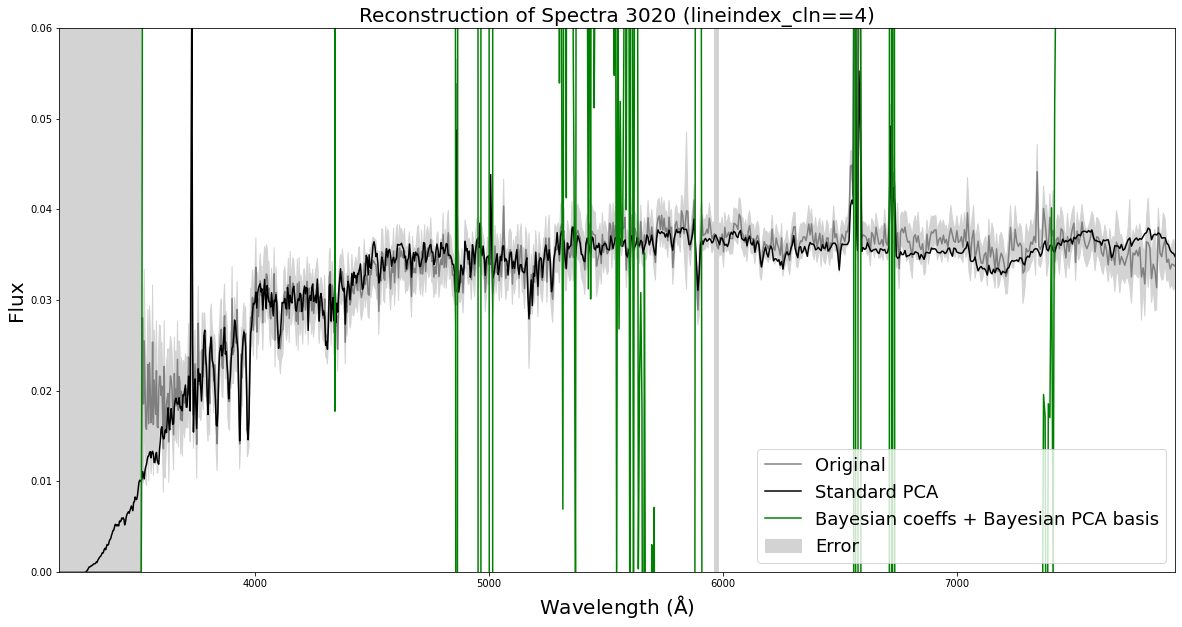

In [ ]:
spec_num = 3020
fig = plt.figure(figsize=(20,10))

plt.plot(wavelengths, X_norm_zeros[spec_num], '-', c='gray', label='Original')
plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spec_num], pca.components_), '-k', label='Standard PCA')
#plt.plot(wavelengths, pca.mean_ + np.dot(bayesian_coeffs(W, X_mu_zeros[spec_num],sig_inv_diag_arr[spec_num], ident), W.T), '-b', label='Bayesian coeffs + standard PCA basis')
#plt.plot(wavelengths, pca.mean_ + np.dot(X_red[spec_num], np.array(W_new_optimised[0]).T), '-b', label='Standard coeffs + Bayesian PCA basis')
plt.plot(wavelengths, pca.mean_ + np.dot(bayesian_coeffs(W, X_mu_zeros[spec_num],sig_inv_diag_arr[spec_num],ident), W_new_optimised[0].T), '-g', label='Bayesian coeffs + Bayesian PCA basis')

spec_err_norm_large = np.copy(spec_err_norm_inf)
spec_err_norm_large[spec_err_norm_large==np.inf] = 10
plt.fill_between(wavelengths, X_norm_zeros[spec_num] - spec_err_norm_large[spec_num], X_norm_zeros[spec_num] + spec_err_norm_large[spec_num] , color = 'lightgrey', label='Error')
#plt.plot(wavelengths,spec_err_norm_large[spec_num], color='orange', label='Error')
#plt.fill_between(wavelengths, X_norm_zeros[spec_num] - spec_err_norm_inf[spec_num], X_norm_zeros[spec_num] + spec_err_norm_inf[spec_num] , color = 'lightgrey', label='Error')
#plt.plot(wavelengths,spec_err_norm_inf[spec_num], color='orange', label='Error')
plt.ylim(0,0.06)
plt.xlim(wavelengths[0],wavelengths[-1])

plt.ylabel('Flux', fontsize=20)
plt.xlabel(r'${\rm Wavelength\ (\AA)}$', fontsize=20)
plt.title(f'Reconstruction of Spectra {spec_num} (lineindex_cln=={subclass[spec_num]})', fontsize=20)
plt.legend(fontsize=18)
plt.show()

# Bayesian PCA coeffs while optimising W

In [ ]:
def optimise_W(W, learning_rate=1e-5, num_iterations=10):
  param_list = [1*W]
  learning_rate = 1e-5
  opt_init, opt_update, get_params = jax.experimental.optimizers.adam(learning_rate)
  opt_state = opt_init(param_list)

  #@partial(jit, static_argnums=(2))
  def update(step, opt_state, data1):
    params = get_params(opt_state)
    value, grads = jax.value_and_grad(ln_allspec)(params,data1)
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

  num_iterations = 10

  data1 = (jnp.array(X_mu_zeros), jnp.array(sig_inv_diag_arr), jnp.array(logdet_sig_arr), ident)
  for step in range(num_iterations):
    # Could potentially also iterate over batches of data
    loss_value, opt_state = update(step, opt_state, data1)

    W_new = get_params(opt_state)
    coeffs_optimised = np.zeros(4)
    for i in range(X_mu_zeros.shape[0]):
      coeffs_optimised = np.vstack((coeffs_optimised, bayesian_coeffs(np.asarray(W_new[0]), X_mu_zeros[i],sig_inv_diag_arr[i], ident)))
    coeffs_optimised = np.delete(coeffs_optimised, 0, 0)
    coeff_diff = coeffs_optimised - X_red
    plt.figure(figsize=(20,10))
    plt.set_cmap('plasma')
    plt.suptitle(f'Iteration {step+1}')
    for j in range(coeffs_optimised.shape[1]):
      ax = plt.subplot(2,2,j+1)
      ax.scatter(range(coeffs_optimised.shape[0]), coeff_diff[:,j], c=subclass)
      ax.set_title(f'Component {j+1}')
      ax.set_xlabel('Spectra number')
      ax.set_ylabel('Optimised Bayesian coeff - Standard PCA coeff')
    plt.subplots_adjust(hspace=.3, wspace=.2)
    plt.show()
  # optimised matrix:
  #W_new_optimised = param_list[0]

  W_new_optimised = get_params(opt_state)

  return W_new_optimised

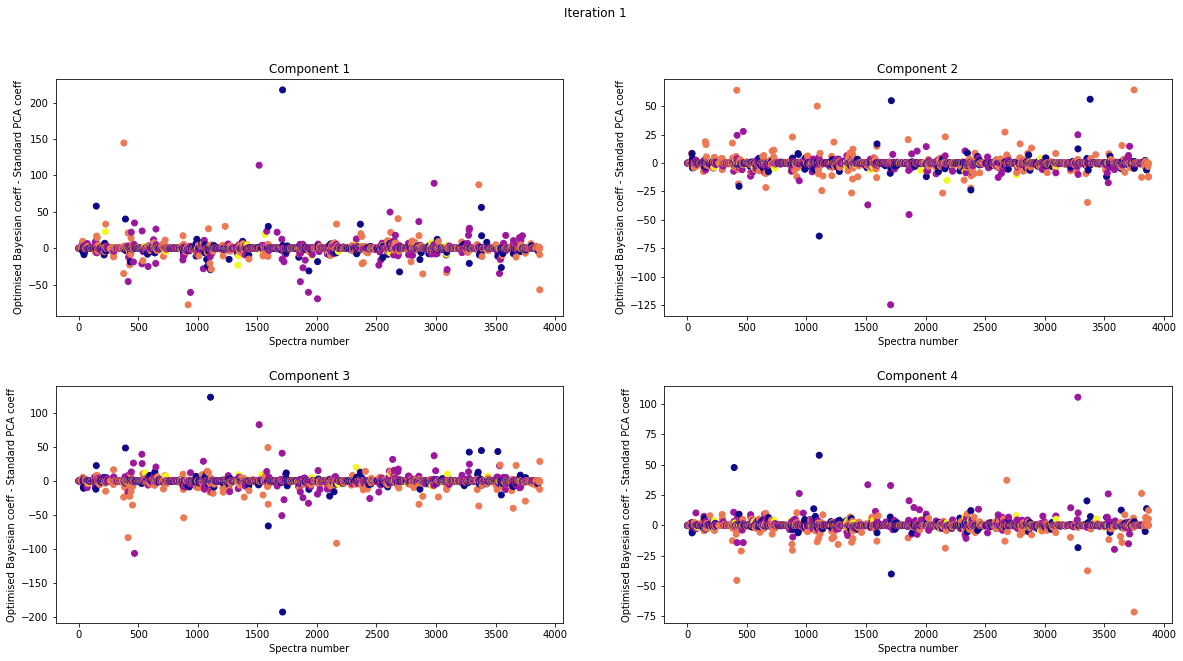

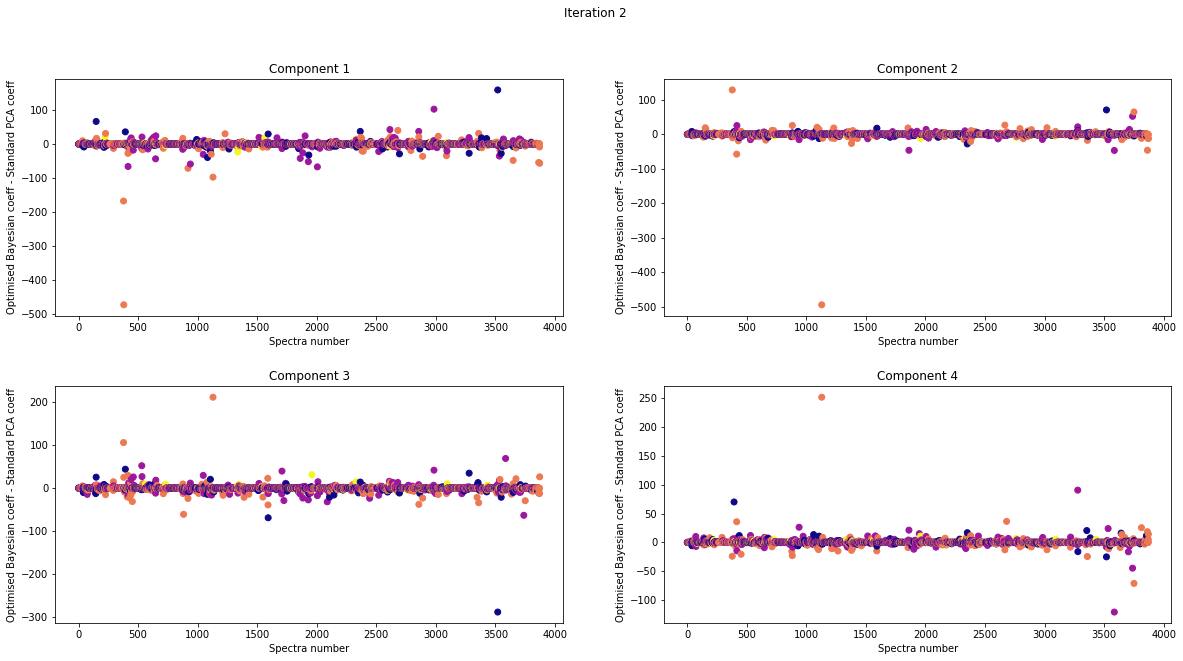

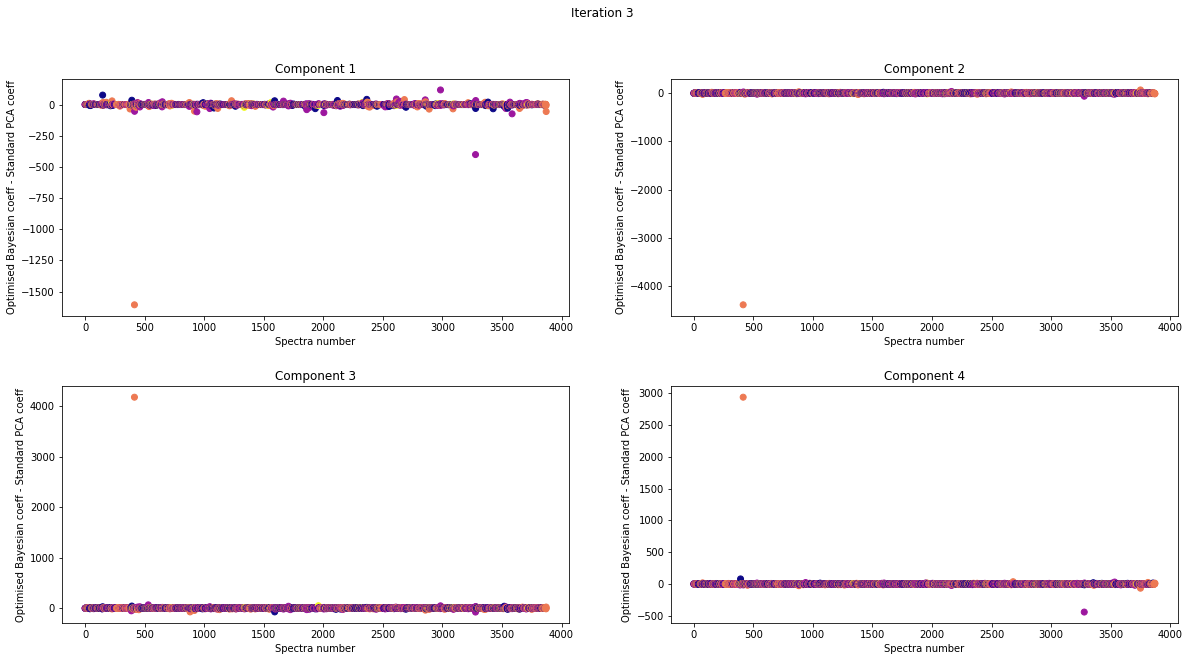

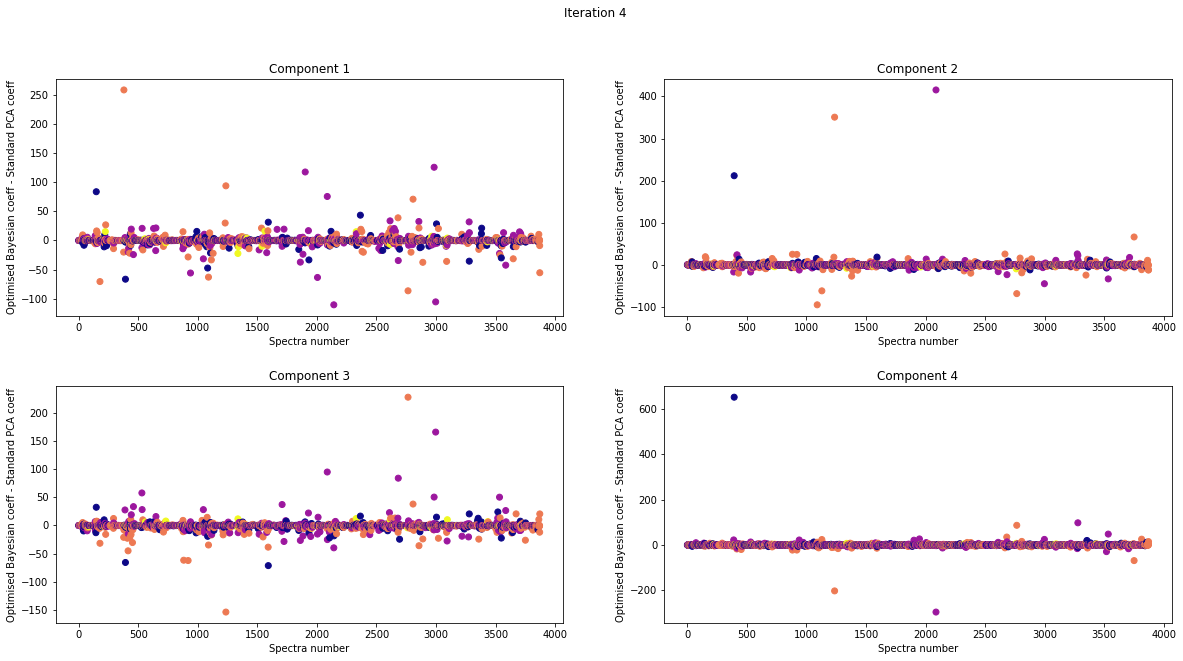

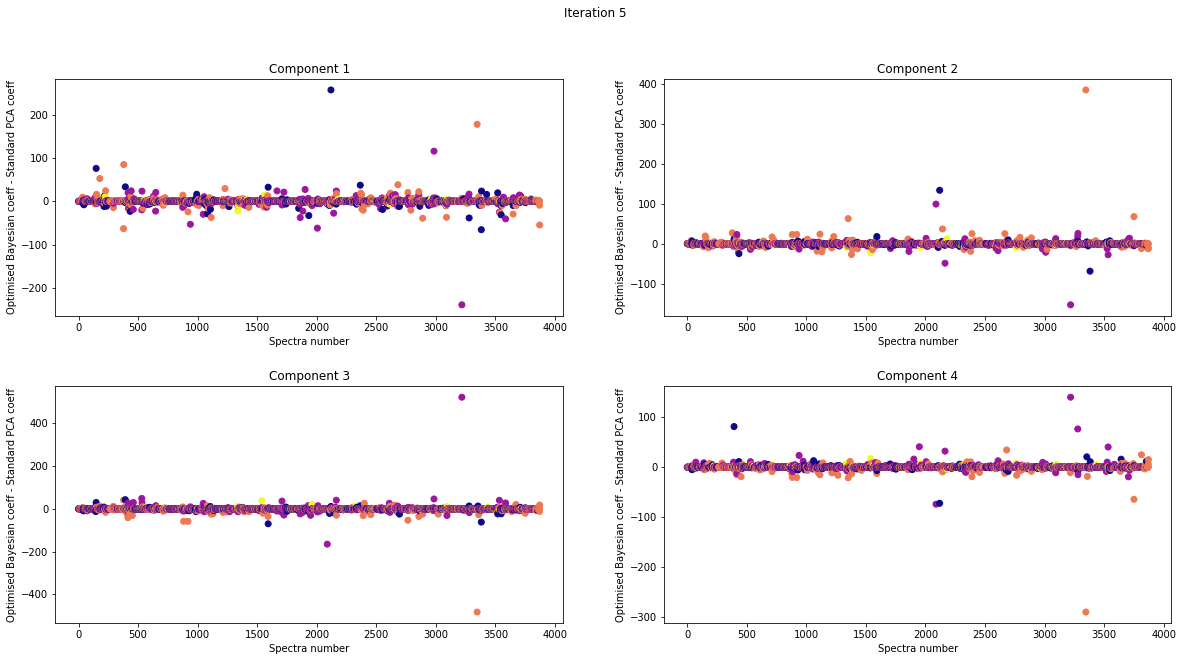

In [ ]:
optimise_W(W, learning_rate=1e-5, num_iterations=10)

# Testing some stuff

In [ ]:
np.sum((sig_inv_diag_arr[0][:,None]*W) * X_mu_zeros[0][:, None], axis=0)

array([-30248.367  ,    197.73984,  -4182.5195 ,  -3542.1206 ],
      dtype=float32)

In [ ]:
(sig_inv_diag_arr[0][:,None]*W) * X_mu_zeros[0][:, None]

array([[   0.       ,    0.       ,    0.       ,   -0.       ],
       [   0.       ,    0.       ,    0.       ,   -0.       ],
       [   0.       ,    0.       ,    0.       ,   -0.       ],
       ...,
       [ -39.094254 , -211.04852  ,  -71.35494  ,   27.235413 ],
       [ -44.20308  , -241.79514  ,  -80.45353  ,   23.620344 ],
       [ -12.633424 ,  -71.46406  ,  -24.258345 ,    6.3777065]],
      dtype=float32)

In [ ]:
sum(((sig_inv_diag_arr[0][:,None]*W) * X_mu_zeros[0][:, None])[:,0])

-30248.367474883795

In [ ]:
(sig_inv_diag_arr[0][:,None] * W).shape

(1000, 4)

In [ ]:
(W*sig_inv_diag_arr[0][:,None]).shape

(1000, 4)

In [ ]:
X_mu_zeros[0].shape

(1000,)

In [ ]:
X_red

array([[-0.09938267, -0.0519083 ,  0.01767215, -0.05450213],
       [-0.1397948 , -0.04367354,  0.03041004,  0.02972106],
       [-0.11165594, -0.02260336,  0.00987963,  0.01481217],
       ...,
       [ 0.12437663,  0.28532866, -0.00784542, -0.03131866],
       [ 0.0124245 , -0.03130134, -0.02275036,  0.04658055],
       [ 0.04610867,  0.07033399, -0.0520631 ,  0.07337584]],
      dtype=float32)

In [ ]:
np.matmul(X_norm_zeros, W)

array([[-0.290825  , -0.09102425, -0.41261768, -0.05717829],
       [-0.33123744, -0.08278903, -0.39987907,  0.02704535],
       [-0.30309862, -0.06171912, -0.42040947,  0.01213671],
       ...,
       [-0.06706611,  0.24621296, -0.43813476, -0.03399428],
       [-0.17901818, -0.07041702, -0.45303977,  0.04390481],
       [-0.1453341 ,  0.03121829, -0.4823526 ,  0.0707002 ]],
      dtype=float32)